<a href="https://colab.research.google.com/github/MovinduSenura/Chest-Xray-Pneumonia-Detection/blob/dev-oshan/notebooks/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

if not os.path.exists("Chest-Xray-Pneumonia-Detection"):
    !git clone https://github.com/MovinduSenura/Chest-Xray-Pneumonia-Detection.git

Cloning into 'Chest-Xray-Pneumonia-Detection'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 265 (delta 17), reused 7 (delta 7), pack-reused 224 (from 2)
Receiving objects: 100% (265/265), 1.64 MiB | 24.30 MiB/s, done.
Resolving deltas: 100% (118/118), done.


In [2]:
%cd Chest-Xray-Pneumonia-Detection

/content/Chest-Xray-Pneumonia-Detection


In [3]:
# ==============================================
# 1️⃣ SETUP ENVIRONMENT AND INSTALL LIBRARIES
# ==============================================

!pip install tensorflow keras matplotlib numpy scikit-learn seaborn pandas

from google.colab import drive
drive.mount('/content/drive')

import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


Mounted at /content/drive


In [5]:
# ==============================================
# 2️⃣ LOAD DATASET USING SHARED PREPROCESSING FILE
# ==============================================

# Import the shared generator function from the repo
from notebooks.preprocessing_2 import create_generators

DATA_DIR = '/content/drive/MyDrive/chest_xray'
train_gen, val_gen, test_gen = create_generators(DATA_DIR)


Found 5216 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
# ==============================================
# 3️⃣ BUILD AND COMPILE RESNET50 MODEL
# ==============================================

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Load pretrained ResNet50 base (no top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for our classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Fine-tune last 30 layers
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 15,499,777 (59.13 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

In [7]:
# ==============================================
# 4️⃣ TRAIN MODEL WITH CALLBACKS
# ==============================================

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/Chest_Xray_Model/best_model.keras',
                    monitor='val_accuracy', save_best_only=True, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8271 - loss: 1.1726
Epoch 1: val_accuracy improved from -inf to 0.74297, saving model to /content/drive/MyDrive/Chest_Xray_Model/best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 2023s 12s/step - accuracy: 0.8274 - loss: 1.1721 - val_accuracy: 0.7430 - val_loss: 1.3002 - learning_rate: 1.0000e-05
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.9088 - loss: 0.9960
Epoch 2: val_accuracy improved from 0.74297 to 0.93095, saving model to /content/drive/MyDrive/Chest_Xray_Model/best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 192s 869ms/step - accuracy: 0.9088 - loss: 0.9959 - val_accuracy: 0.9309 - val_loss: 0.9478 - learning_rate: 1.0000e-05
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.9189 - loss: 0.9477
Epoch 3: val_accuracy did not improve from 0.93095
163/163 ━━━━━━━━━━━━━━━━━━━━ 146s 898ms/step - accuracy: 0.9189 - loss: 0.9476 - val_accuracy: 0.7647 - val_loss: 1.3423 - learning_rate

25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 512ms/step - accuracy: 0.9630 - loss: 0.7767
20/20 ━━━━━━━━━━━━━━━━━━━━ 517s 27s/step - accuracy: 0.7631 - loss: 1.4553

✅ Validation Accuracy: 0.9642
✅ Test Accuracy: 0.8478


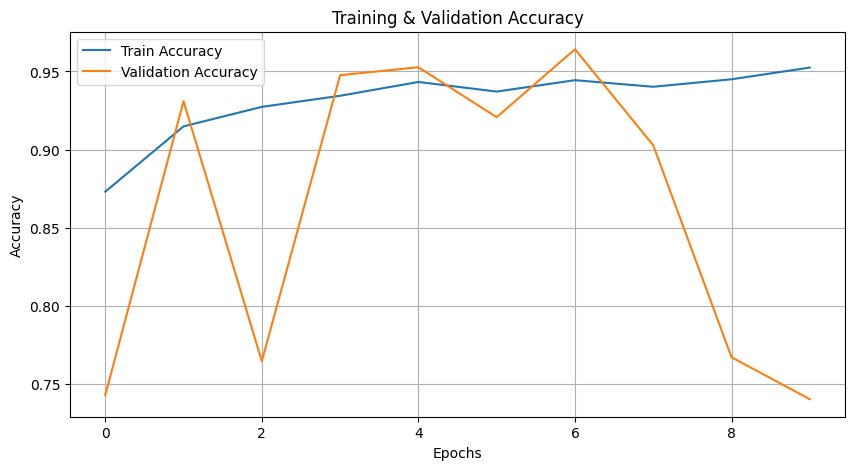

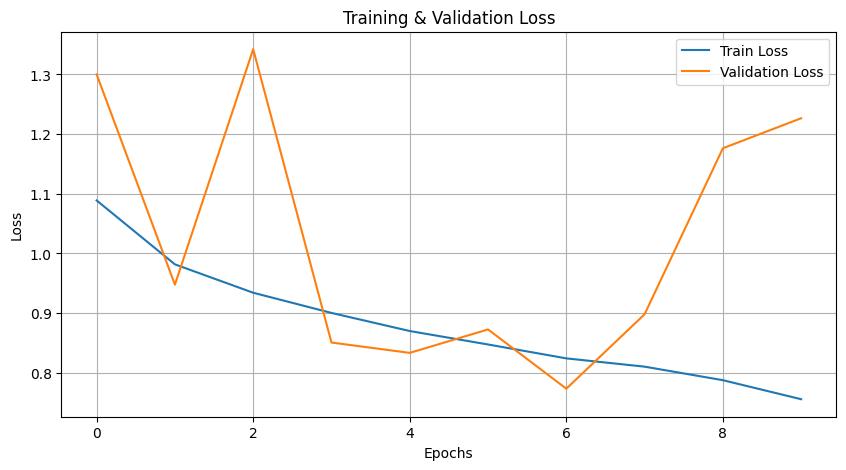

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 561ms/step


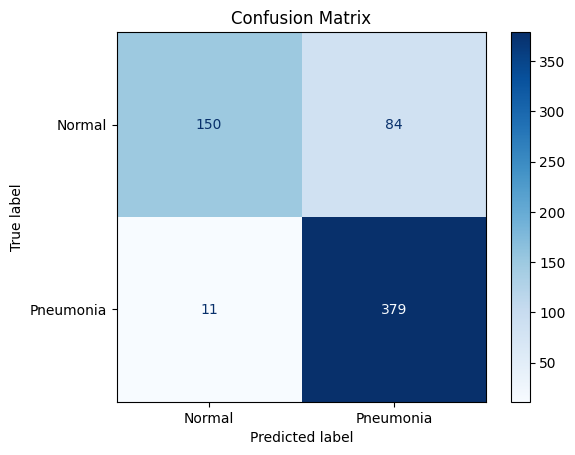

Precision: 0.8610, Recall: 0.8478, F1-Score: 0.8402


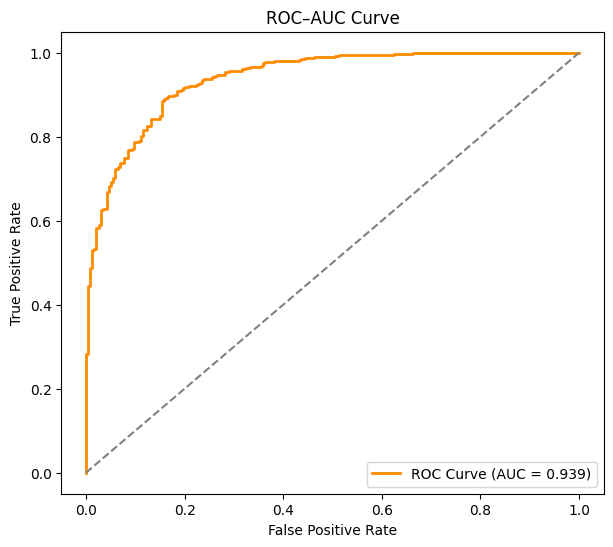

In [8]:
# ==============================================
# 5️⃣ EVALUATION, VISUALIZATION, AND RESULT SAVING
# ==============================================

from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support

# Load best model for evaluation
best_model = load_model('/content/drive/MyDrive/Chest_Xray_Model/best_model.keras')

# Evaluate on validation and test sets
val_loss, val_acc = best_model.evaluate(val_gen)
test_loss, test_acc = best_model.evaluate(test_gen)

print(f"\n✅ Validation Accuracy: {val_acc:.4f}")
print(f"✅ Test Accuracy: {test_acc:.4f}")

# =================================================
# Visualization - Accuracy and Loss Curves
# =================================================
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)
plt.show()

# =================================================
# Confusion Matrix and Classification Report
# =================================================
y_true = test_gen.classes
y_pred = best_model.predict(test_gen)
y_pred_classes = (y_pred > 0.5).astype("int32")

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot(cmap='Blues'); plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_true, y_pred_classes, target_names=['Normal', 'Pneumonia'], output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# =================================================
# ROC–AUC Curve
# =================================================
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC–AUC Curve')
plt.legend(); plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step


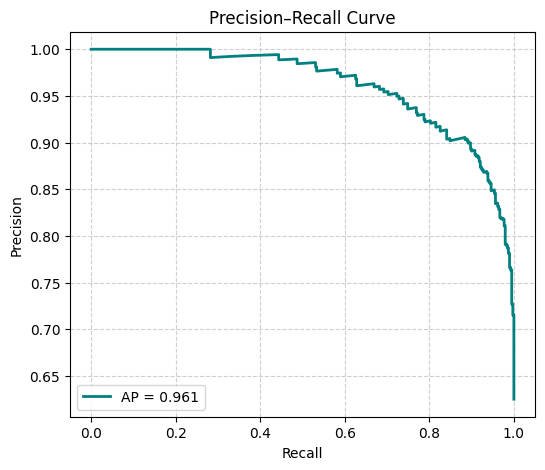

              precision    recall  f1-score   support

           0       0.93      0.64      0.76       234
           1       0.82      0.97      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.81      0.82       624
weighted avg       0.86      0.85      0.84       624



/tmp/ipython-input-1822978251.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='viridis')


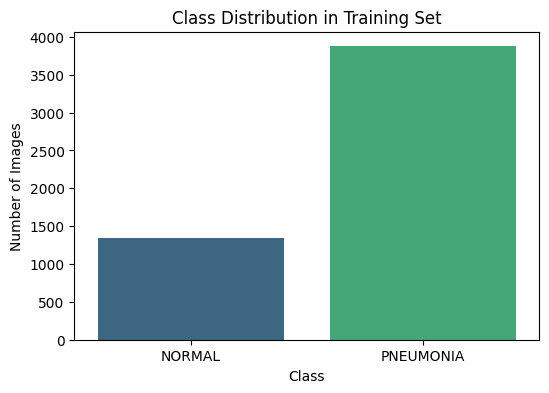

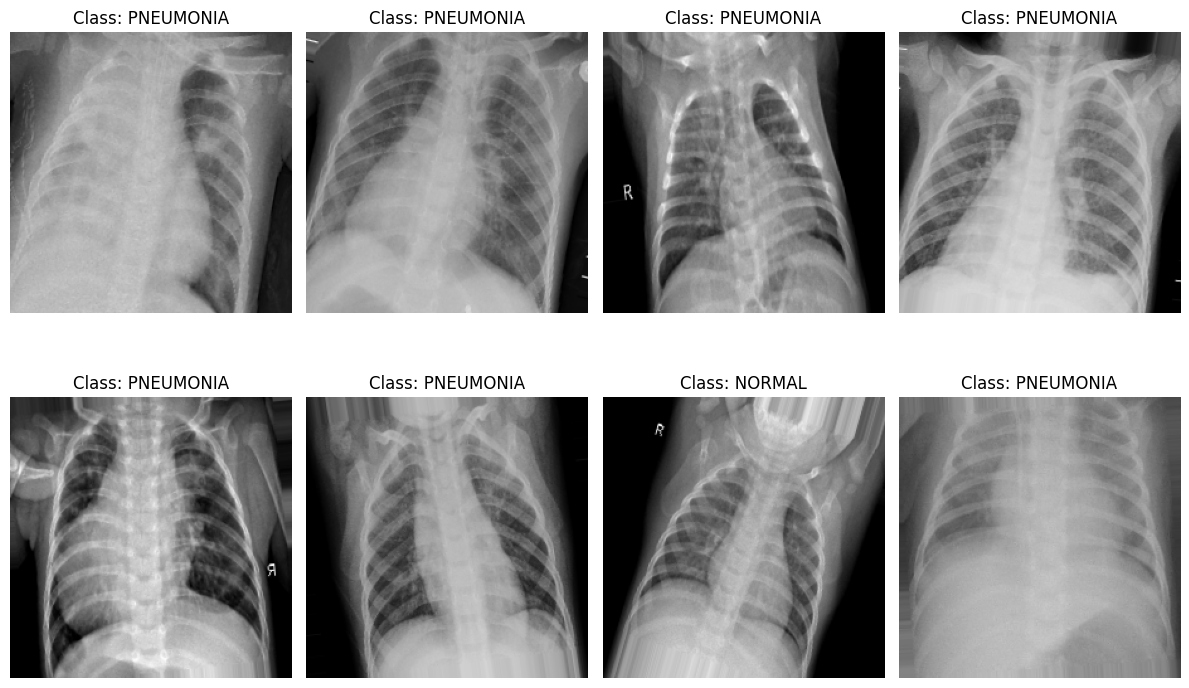

In [10]:
#Precision–Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

y_pred_proba = best_model.predict(test_gen).ravel()
precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
avg_precision = average_precision_score(y_true, y_pred_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='teal', lw=2, label=f'AP = {avg_precision:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#Classification Report
print(classification_report(y_true, y_pred_classes))

# Extract class indices and labels
labels = list(train_gen.class_indices.keys())

# Get the class names for each image in the training generator
class_names = [labels[i] for i in train_gen.classes]

# Create a DataFrame for easier plotting
df = pd.DataFrame({'Class': class_names})

# Plot using seaborn
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df, palette='viridis')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

#Dataset Visualization

# Get one batch of images and labels
x_batch, y_batch = next(train_gen)

plt.figure(figsize=(12,8))
for i in range(8):  # display first 8 images
    plt.subplot(2,4,i+1)
    plt.imshow(x_batch[i])

    # Since class_mode='binary', y_batch[i] is 0 or 1
    class_label = list(train_gen.class_indices.keys())[int(y_batch[i])]
    plt.title(f"Class: {class_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
# ==============================================
# 6️⃣ SAVE MODEL, PLOTS, AND METRICS TO CSV LOG
# ==============================================

import csv

# Create Result_Final directory
base_dir = '/content/drive/MyDrive/Chest_Xray_Model/Result_Final'
os.makedirs(base_dir, exist_ok=True)

# Create timestamped subfolder
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
run_folder = os.path.join(base_dir, f"run_{timestamp}")
os.makedirs(run_folder, exist_ok=True)

# Save model
model_path = os.path.join(run_folder, "ResNet50_model.keras")
best_model.save(model_path)

# Save accuracy/loss plots
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend(); plt.title('Accuracy')
plt.savefig(os.path.join(run_folder, "accuracy_plot.png")); plt.close()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.savefig(os.path.join(run_folder, "loss_plot.png")); plt.close()

# Save confusion matrix
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.savefig(os.path.join(run_folder, "confusion_matrix.png"))
plt.close()

# Save ROC curve
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.legend(); plt.title('ROC–AUC Curve')
plt.savefig(os.path.join(run_folder, "roc_curve.png"))
plt.close()

# Write metrics to CSV
csv_file = os.path.join(base_dir, "final_results_log.csv")
fieldnames = ["Timestamp","Epochs","Train_Accuracy","Val_Accuracy","Val_Loss",
              "Test_Accuracy","Test_Loss","Precision","Recall","F1_Score","ROC_AUC","Run_Folder_Path"]

file_exists = os.path.isfile(csv_file)
with open(csv_file, 'a', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    if not file_exists:
        writer.writeheader()
    writer.writerow({
        "Timestamp": timestamp,
        "Epochs": len(history.history['accuracy']),
        "Train_Accuracy": history.history['accuracy'][-1],
        "Val_Accuracy": val_acc,
        "Val_Loss": val_loss,
        "Test_Accuracy": test_acc,
        "Test_Loss": test_loss,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "ROC_AUC": roc_auc,
        "Run_Folder_Path": run_folder
    })

print(f"\n✅ Final results saved in: {run_folder}")
print(f"📊 Metrics logged in: {csv_file}")



✅ Final results saved in: /content/drive/MyDrive/Chest_Xray_Model/Result_Final/run_2025-10-11_15-42-10
📊 Metrics logged in: /content/drive/MyDrive/Chest_Xray_Model/Result_Final/final_results_log.csv
